In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_smooth
import plotnine as p9

In [2]:
data_dirpath = Path('../..') / 'data'
output_dirpath = data_dirpath / 'output/imputation'
openml_dirpath = data_dirpath / 'openml'
fig_dirpath = output_dirpath / 'fig'
fig_dirpath.mkdir(parents=True, exist_ok=True)

baseline_methods = ['meanmode', 'knn', 'rf']
llm_models = [
  # 'meta-llama/Llama-2-13b-chat-hf', 
  'meta-llama/Llama-2-70b-chat-hf', 
  # 'mistralai/Mistral-7B-Instruct-v0.2', 
  'mistralai/Mixtral-8x7B-Instruct-v0.1'
]
imputation_methods = baseline_methods.copy()
[imputation_methods.append(f'llm/expert/{model}') for model in llm_models]

[None, None]

# Preprocessing

In [3]:
def fetch_openml_description_length(openml_dirpath: Path):
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    dataset_length_dict = {}
    for openml_id in dataset_list['did']:
        dataset_description_filepath = openml_dirpath / f'{openml_id}/description.txt'
        with open(dataset_description_filepath) as f:
            dataset_description = f.read()
            dataset_description_length = len(dataset_description)
            dataset_length_dict[openml_id] = dataset_description_length
    return dataset_length_dict

dataset_length_dict = fetch_openml_description_length(openml_dirpath)

In [4]:
def fetch_openml_num_features(openml_dirpath: Path):
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    dataset_num_features_dict = { openml_id: n_features-1 for openml_id, n_features in zip(dataset_list['did'], dataset_list['NumberOfFeatures']) }
    return dataset_num_features_dict

dataset_num_features_dict = fetch_openml_num_features(openml_dirpath)

In [5]:
def fetch_openml_category(openml_dirpath: Path):
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    # update natural language processing -> NLP
    dataset_list['category (manually)'] = dataset_list['category (manually)'].replace('natural language processing', 'NLP')
    dataset_category_dict = { openml_id: category for openml_id, category in zip(dataset_list['did'], dataset_list['category (manually)']) }
    return dataset_category_dict

dataset_category_dict = fetch_openml_category(openml_dirpath)

In [6]:
def fetch_openml_task_runs(openml_dirpath: Path):
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    # update natural language processing -> NLP
    dataset_category_dict = { openml_id: category for openml_id, category in zip(dataset_list['did'], dataset_list['tasks_runs']) }
    return dataset_category_dict

dataset_task_runs = fetch_openml_task_runs(openml_dirpath)

In [7]:
rmse_df = pd.DataFrame(columns=['method', 'openml_id', 'openml_desc_len', 'category', 'n_features', 'rmse'])
macro_f1_df = pd.DataFrame(columns=['method', 'openml_id', 'openml_desc_len', 'category', 'n_features', 'macro_f1'])
downstream_df = pd.DataFrame(columns=['method', 'openml_id', 'openml_desc_len', 'category', 'n_features', 'accuracy', 'macro_f1'])
corrected_method_name = {
    'meanmode': 'Mean/Mode', 
    'knn': '$k$-NN', 
    'rf': 'Random Forest', 
    'llm/expert/meta-llama/Llama-2-13b-chat-hf': 'LLaMA 2 13B Chat', 
    'llm/expert/meta-llama/Llama-2-70b-chat-hf': 'LLaMA 2 70B Chat', 
    'llm/expert/mistralai/Mistral-7B-Instruct-v0.2': 'Mistral 7B Instruct',
    'llm/expert/mistralai/Mixtral-8x7B-Instruct-v0.1': 'Mixtral 8x7B Instruct',
}

for method in imputation_methods:
    method_output_dirpath = output_dirpath / method
    method_imputation_results_filepath = method_output_dirpath / f'imputation_complete.csv'
    method_imputation_results = pd.read_csv(method_imputation_results_filepath, header=0)
    method_imputation_results = method_imputation_results.drop(['timestamp'], axis=1)
    method_imputation_results['method_id'] = list(corrected_method_name.keys()).index(method)
    method_imputation_results['method'] = corrected_method_name[method]
    method_imputation_results['openml_desc_len'] = method_imputation_results['openml_id'].map(dataset_length_dict)
    method_imputation_results['category'] = method_imputation_results['openml_id'].map(dataset_category_dict)
    method_imputation_results['tasks_runs'] = method_imputation_results['openml_id'].map(dataset_task_runs)
    method_imputation_results['n_features'] = method_imputation_results['openml_id'].map(dataset_num_features_dict)

    rmse_df = pd.concat([rmse_df, method_imputation_results.drop(['macro_f1', 'missing_column_name', 'missing_column_type', 'missingness'], axis=1).dropna()])
    macro_f1_df = pd.concat([macro_f1_df, method_imputation_results.drop(['rmse', 'missing_column_name', 'missing_column_type', 'missingness'], axis=1).dropna()])

    method_downstream_results_filepath = method_output_dirpath / f'downstream_complete.csv'
    method_downstream_results = pd.read_csv(method_downstream_results_filepath, header=0)
    method_downstream_results = method_downstream_results.drop(['timestamp'], axis=1)
    method_downstream_results['method_id'] = list(corrected_method_name.keys()).index(method)
    method_downstream_results['method'] = corrected_method_name[method]
    method_downstream_results['openml_desc_len'] = method_downstream_results['openml_id'].map(dataset_length_dict)
    method_downstream_results['category'] = method_downstream_results['openml_id'].map(dataset_category_dict)
    method_downstream_results['tasks_runs'] = method_downstream_results['openml_id'].map(dataset_task_runs)
    method_downstream_results['n_features'] = method_downstream_results['openml_id'].map(dataset_num_features_dict)
    
    downstream_df = pd.concat([downstream_df, method_downstream_results.dropna()])

# rmse_df = rmse_df.groupby(['method', 'method_id', 'openml_id', 'openml_desc_len', 'category']).mean().reset_index()
rmse_df = rmse_df.sort_values('method_id').reset_index(drop=True)

# macro_f1_df = macro_f1_df.groupby(['method', 'method_id', 'openml_id', 'openml_desc_len', 'category']).mean().reset_index()
macro_f1_df = macro_f1_df.sort_values('method_id').reset_index(drop=True)

downstream_df = downstream_df.groupby(['method', 'method_id', 'openml_id', 'openml_desc_len', 'category', 'missingness']).mean().reset_index()
downstream_df = downstream_df.sort_values('method_id').reset_index(drop=True)

/var/folders/mr/qc9n5qqn4jjgn6jh4mpcfsgm0000gn/T/ipykernel_77343/2960762626.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/var/folders/mr/qc9n5qqn4jjgn6jh4mpcfsgm0000gn/T/ipykernel_77343/2960762626.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/var/folders/mr/qc9n5qqn4jjgn6jh4mpcfsgm0000gn/T/ipykernel_77343/2960762626.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA

In [8]:
rmse_df

,method,openml_id,openml_desc_len,category,n_features,rmse,n_missing_values,method_id,tasks_runs
0,Mean/Mode,6,1057,computer vision,16,0.171829,24.0,0.0,69914.0
1,Mean/Mode,1494,4844,biology,41,0.374026,18.0,0.0,267861.0
2,Mean/Mode,1497,3130,engineering,24,0.150103,17.0,0.0,25664.0
3,Mean/Mode,1497,3130,engineering,24,0.259280,18.0,0.0,25664.0
4,Mean/Mode,1497,3130,engineering,24,0.197652,16.0,0.0,25664.0
...,...,...,...,...,...,...,...,...,...
715,Mixtral 8x7B Instruct,458,999,NLP,70,0.671311,19.0,6.0,29024.0
716,Mixtral 8x7B Instruct,458,999,NLP,70,0.401295,20.0,6.0,29024.0
717,Mixtral 8x7B Instruct,458,999,NLP,70,0.395408,15.0,6.0,29024.0
718,Mixtral 8x7B Instruct,300,2165,NLP,617,0.421324,14.0,6.0,50888.0


In [9]:
rmse_df.to_csv(output_dirpath / 'rmse.csv', index=False)

In [10]:
downstream_baseline_df_filepath = output_dirpath / 'baseline/train_incomplete/downstream_complete.csv'
downstream_baseline_df = pd.read_csv(downstream_baseline_df_filepath, header=0)
downstream_baseline_df = downstream_baseline_df.drop(['timestamp'], axis=1)
downstream_baseline_df['method'] = 'Baseline'
downstream_baseline_df['method_id'] = -1
downstream_baseline_df['openml_desc_len'] = downstream_baseline_df['openml_id'].map(dataset_length_dict)
downstream_baseline_df['category'] = downstream_baseline_df['openml_id'].map(dataset_category_dict)
downstream_baseline_df['n_features'] = downstream_baseline_df['openml_id'].map(dataset_num_features_dict)
downstream_baseline_df = downstream_baseline_df.groupby(['method', 'method_id', 'openml_id', 'openml_desc_len', 'category', 'missingness']).mean().reset_index()
downstream_baseline_df = downstream_baseline_df.sort_values('method_id').reset_index(drop=True)

In [11]:
downstream_baseline_df

,method,method_id,openml_id,openml_desc_len,category,missingness,accuracy,macro_f1,n_features
0,Baseline,-1,3,3178,board game,MAR,0.984375,0.984320,36.0
1,Baseline,-1,1475,838,computer science,MAR,0.608660,0.514923,51.0
2,Baseline,-1,1478,3817,computer vision,MAR,0.975728,0.975478,561.0
3,Baseline,-1,1480,1631,medicine,MAR,0.735043,0.621912,10.0
4,Baseline,-1,1485,2200,computer science,MAR,0.701923,0.700567,500.0
...,...,...,...,...,...,...,...,...,...
59,Baseline,-1,1063,2473,computer science,MAR,0.809524,0.678703,21.0
60,Baseline,-1,1067,2509,computer science,MAR,0.860190,0.643515,21.0
61,Baseline,-1,1068,2532,engineering,MAR,0.923423,0.575144,21.0
62,Baseline,-1,40996,1094,computer vision,MAR,0.880000,0.878120,784.0


In [12]:
def downstream_performance(downstream_df: pd.DataFrame):
    # calculate accuracy(method) / (accuracy(best) - accuracy(baseline))
    downstream_df_copy = downstream_df.copy()
    for openml_id in downstream_baseline_df['openml_id']:
        baseline_accuracy = downstream_baseline_df[downstream_baseline_df['openml_id'] == openml_id]['accuracy'].values[0]
        best_accuracy = downstream_df_copy[downstream_df['openml_id'] == openml_id]['accuracy'].max()
        baseline_f1 = downstream_baseline_df[downstream_baseline_df['openml_id'] == openml_id]['macro_f1'].values[0]
        best_f1 = downstream_df_copy[downstream_df['openml_id'] == openml_id]['macro_f1'].max()
        # downstream_df_copy.loc[downstream_df_copy['openml_id'] == openml_id, 'effect_accuracy'] = downstream_df_copy[downstream_df_copy['openml_id'] == openml_id]['accuracy'] / (baseline_accuracy) - 1
        downstream_df_copy.loc[downstream_df_copy['openml_id'] == openml_id, 'effect_accuracy'] = (downstream_df_copy[downstream_df_copy['openml_id'] == openml_id]['accuracy'] - baseline_accuracy) / baseline_accuracy * 100
        # downstream_df_copy.loc[downstream_df_copy['openml_id'] == openml_id, 'effect_macro_f1'] = downstream_df_copy[downstream_df_copy['openml_id'] == openml_id]['macro_f1'] / (baseline_f1) - 1
        downstream_df_copy.loc[downstream_df_copy['openml_id'] == openml_id, 'effect_macro_f1'] = (downstream_df_copy[downstream_df_copy['openml_id'] == openml_id]['macro_f1'] - baseline_f1) / baseline_f1 * 100
    return downstream_df_copy

In [13]:
downstream_df = downstream_performance(downstream_df)

In [14]:
downstream_df

,method,method_id,openml_id,openml_desc_len,category,missingness,n_features,accuracy,macro_f1,tasks_runs,effect_accuracy,effect_macro_f1
0,Mean/Mode,0.0,1478,3817,computer vision,MAR,561.0,0.978641,0.978286,24543.0,0.298507,0.287855
1,Mean/Mode,0.0,1068,2532,engineering,MAR,21.0,0.914414,0.564391,149998.0,-0.975610,-1.869504
2,Mean/Mode,0.0,1067,2509,computer science,MAR,21.0,0.857820,0.647393,161516.0,-0.275482,0.602676
3,Mean/Mode,0.0,1063,2473,computer science,MAR,21.0,0.800000,0.669366,176906.0,-1.176471,-1.375691
4,Mean/Mode,0.0,1050,1235,engineering,MAR,37.0,0.894569,0.569356,146026.0,1.083032,14.858135
...,...,...,...,...,...,...,...,...,...,...,...,...
300,Mixtral 8x7B Instruct,6.0,1501,2297,computer vision,MAR,256.0,0.937304,0.936006,33402.0,2.047782,2.104229
301,Mixtral 8x7B Instruct,6.0,1497,3130,engineering,MAR,24.0,0.991758,0.987753,25664.0,0.092421,0.113531
302,Mixtral 8x7B Instruct,6.0,1494,4844,biology,MAR,41.0,0.886256,0.874330,267861.0,2.185792,2.343345
303,Mixtral 8x7B Instruct,6.0,32,3577,computer vision,MAR,16.0,0.992724,0.992770,37686.0,0.045830,0.041604


In [15]:
macro_f1_df
macro_f1_df.to_csv(output_dirpath / 'macro_f1.csv', index=False)

In [16]:
downstream_df.to_csv(output_dirpath / 'downstream.csv', index=False)

In [17]:
downstream_df

,method,method_id,openml_id,openml_desc_len,category,missingness,n_features,accuracy,macro_f1,tasks_runs,effect_accuracy,effect_macro_f1
0,Mean/Mode,0.0,1478,3817,computer vision,MAR,561.0,0.978641,0.978286,24543.0,0.298507,0.287855
1,Mean/Mode,0.0,1068,2532,engineering,MAR,21.0,0.914414,0.564391,149998.0,-0.975610,-1.869504
2,Mean/Mode,0.0,1067,2509,computer science,MAR,21.0,0.857820,0.647393,161516.0,-0.275482,0.602676
3,Mean/Mode,0.0,1063,2473,computer science,MAR,21.0,0.800000,0.669366,176906.0,-1.176471,-1.375691
4,Mean/Mode,0.0,1050,1235,engineering,MAR,37.0,0.894569,0.569356,146026.0,1.083032,14.858135
...,...,...,...,...,...,...,...,...,...,...,...,...
300,Mixtral 8x7B Instruct,6.0,1501,2297,computer vision,MAR,256.0,0.937304,0.936006,33402.0,2.047782,2.104229
301,Mixtral 8x7B Instruct,6.0,1497,3130,engineering,MAR,24.0,0.991758,0.987753,25664.0,0.092421,0.113531
302,Mixtral 8x7B Instruct,6.0,1494,4844,biology,MAR,41.0,0.886256,0.874330,267861.0,2.185792,2.343345
303,Mixtral 8x7B Instruct,6.0,32,3577,computer vision,MAR,16.0,0.992724,0.992770,37686.0,0.045830,0.041604


In [18]:
llm_rmse_df = rmse_df.loc[rmse_df['method'].isin(['LLaMA 2 13B Chat', 'LLaMA 2 70B Chat', 'Mistral 7B Instruct', 'Mixtral 8x7B Instruct'])]
llm_rmse_df = llm_rmse_df.loc[:, ['method', 'category', 'rmse', 'openml_desc_len', 'tasks_runs', 'n_features']]
llm_rmse_df = llm_rmse_df.reset_index(drop=True)
llm_rmse_df

,method,category,rmse,openml_desc_len,tasks_runs,n_features
0,LLaMA 2 70B Chat,biology,1.386545,4844,267861.0,41
1,LLaMA 2 70B Chat,NLP,0.476746,4799,218957.0,5
2,LLaMA 2 70B Chat,NLP,0.283641,4799,218957.0,5
3,LLaMA 2 70B Chat,biology,0.521301,4844,267861.0,41
4,LLaMA 2 70B Chat,NLP,0.327062,4799,218957.0,5
...,...,...,...,...,...,...
262,Mixtral 8x7B Instruct,NLP,0.671311,999,29024.0,70
263,Mixtral 8x7B Instruct,NLP,0.401295,999,29024.0,70
264,Mixtral 8x7B Instruct,NLP,0.395408,999,29024.0,70
265,Mixtral 8x7B Instruct,NLP,0.421324,2165,50888.0,617


In [19]:
llm_macro_f1_df = macro_f1_df.loc[macro_f1_df['method'].isin(['LLaMA 2 13B Chat', 'LLaMA 2 70B Chat', 'Mistral 7B Instruct', 'Mixtral 8x7B Instruct'])]
llm_macro_f1_df = llm_macro_f1_df.loc[:, ['method', 'category', 'macro_f1', 'openml_desc_len', 'tasks_runs', 'n_features']]
llm_macro_f1_df = llm_macro_f1_df.reset_index(drop=True)
llm_macro_f1_df

,method,category,macro_f1,openml_desc_len,tasks_runs,n_features
0,LLaMA 2 70B Chat,business,0.190476,2569,65709.0,16
1,LLaMA 2 70B Chat,medicine,0.365942,1631,155162.0,10
2,LLaMA 2 70B Chat,NLP,0.312500,2501,51677.0,30
3,LLaMA 2 70B Chat,NLP,0.369963,2501,51677.0,30
4,LLaMA 2 70B Chat,NLP,0.200000,2501,51677.0,30
...,...,...,...,...,...,...
59,Mixtral 8x7B Instruct,board game,0.407407,3178,274238.0,36
60,Mixtral 8x7B Instruct,board game,0.142857,3178,274238.0,36
61,Mixtral 8x7B Instruct,business,0.392727,2152,7180.0,6
62,Mixtral 8x7B Instruct,NLP,0.345455,5501,26899.0,12


# Imputation quality

## Normalized Root Mean Squared Error (NRMSE)

$$
\text{NRMSE} = \frac{\text{RMSE}}{|x_{\max} - x_{\min}|}
$$
, where $x_{\max}$ and $x_{\min}$ are the maximum and minimum value of the observed (ground truth) values, and
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2}
$$
, where $x_i$ represents the observed (ground truth) value and $\hat{x}_i$ represents the to-be-imputed value.

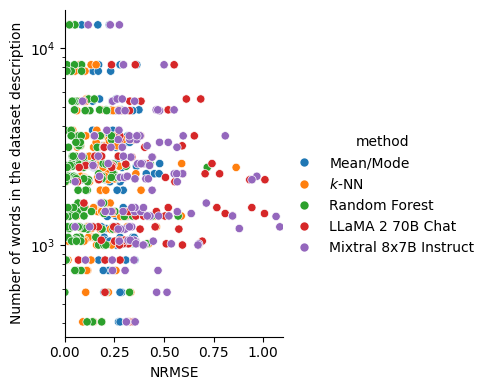

In [20]:
g = sns.relplot(
    data=rmse_df, x='rmse', y='openml_desc_len', hue='method', 
    height=4, aspect=0.9
)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Number of words in the dataset description')
g.ax.set_yscale('log')
g.ax.set_xlim(0.0, 1.1)
g.fig.savefig(output_dirpath / 'fig/nrmse-desclength-all.pdf', bbox_inches='tight')

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/stat_smooth.py:210: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/stat_smooth.py:210: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/stat_smooth.py:210: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points f

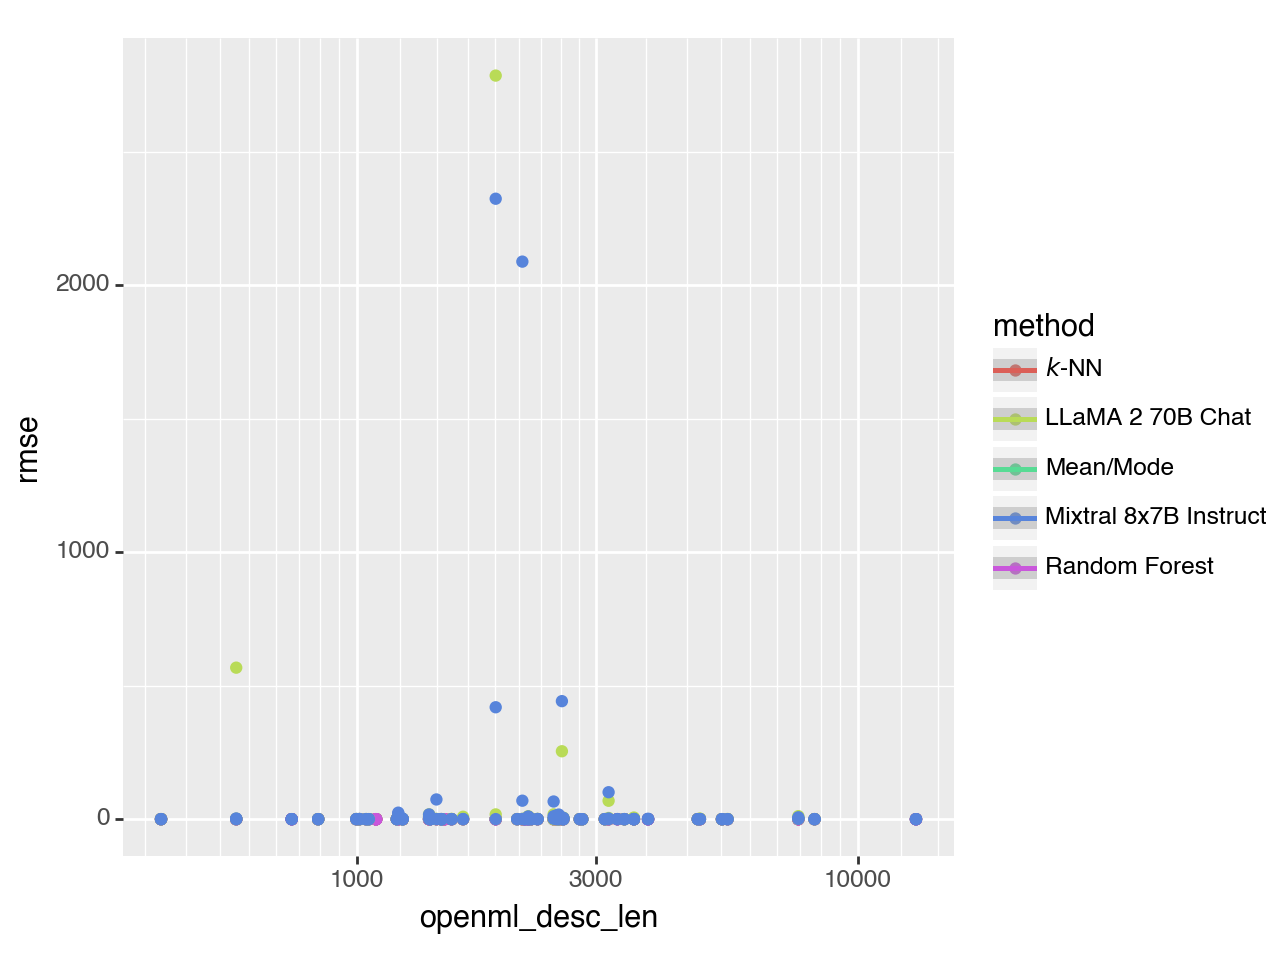

<Figure Size: (640 x 480)>

In [21]:
(
    p9.ggplot(
        data=rmse_df, 
        mapping=aes(x='openml_desc_len', y='rmse', color='method')
    )
    + p9.geom_point()
    + p9.geom_smooth()
    + p9.scale_x_log10()
)

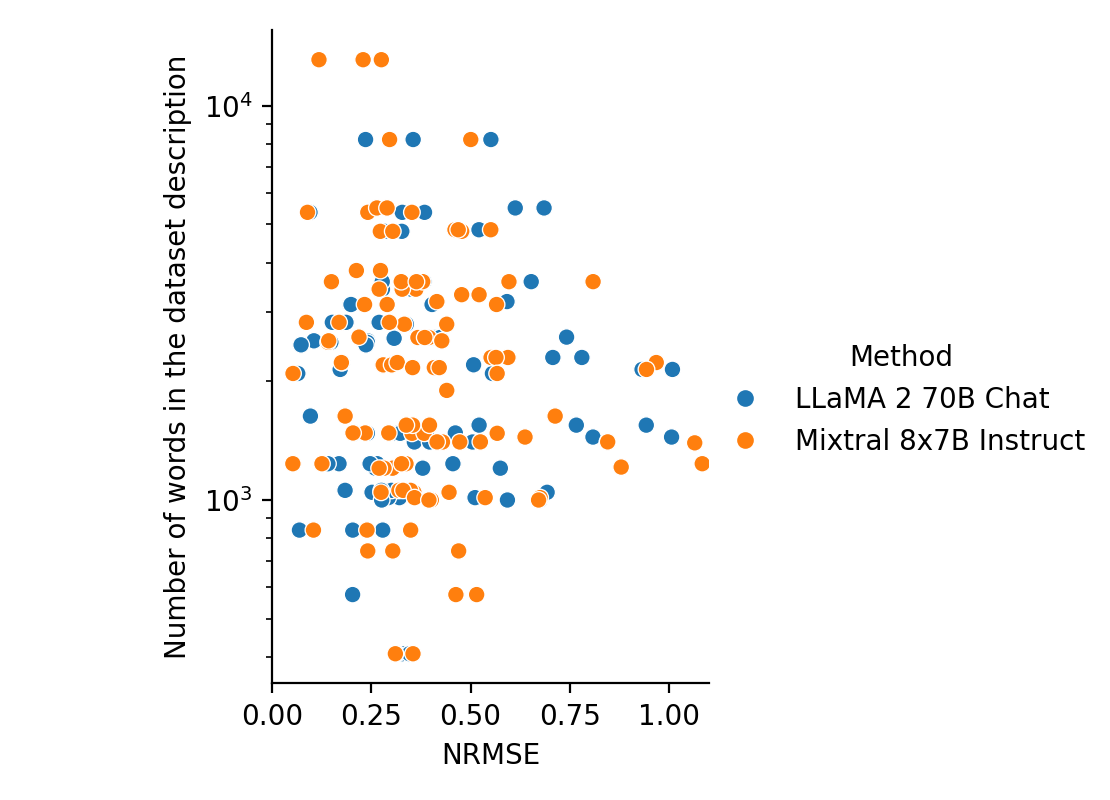

In [22]:
g = sns.relplot(
    data=llm_rmse_df, x='rmse', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Number of words in the dataset description')
g.legend.set_title('Method')
g.ax.set_yscale('log')
g.ax.set_xlim(0, 1.1)
g.fig.savefig(output_dirpath / 'fig/nrmse-desclength-llm.pdf', bbox_inches='tight')

(0.0, 1.1)

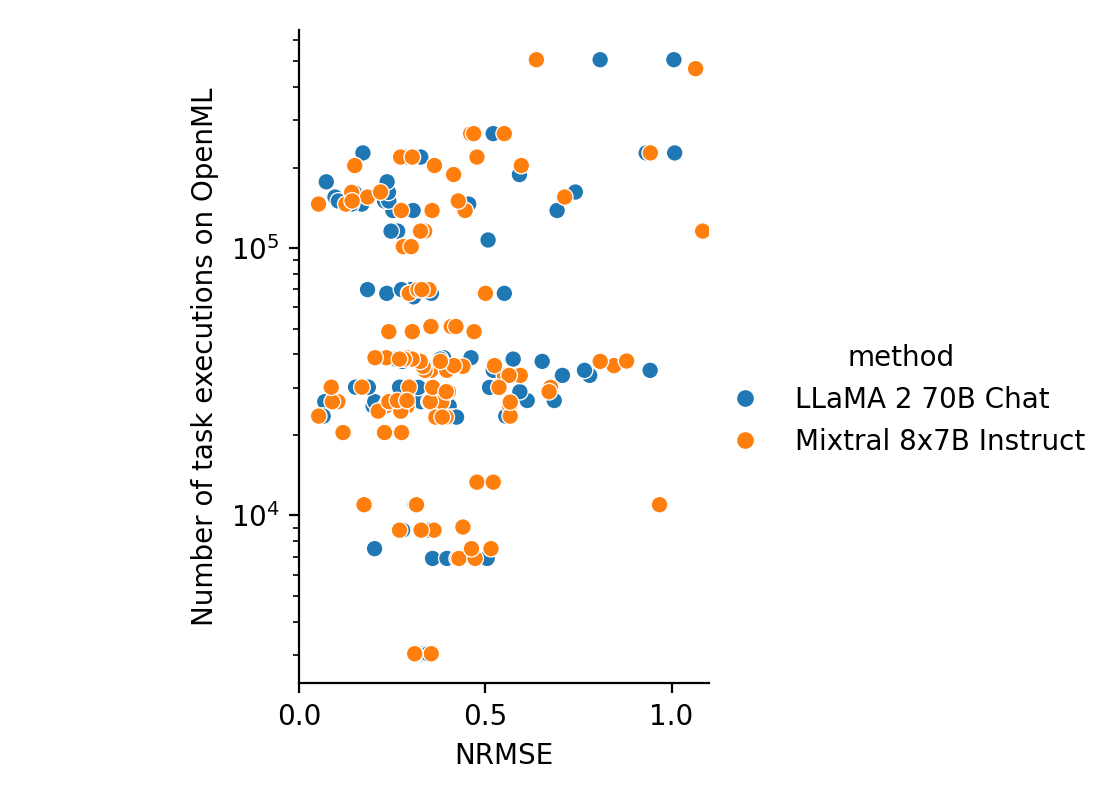

In [23]:
g = sns.relplot(
    data=llm_rmse_df, x='rmse', y='tasks_runs', hue='method', 
    height=4, aspect=0.9
)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Number of task executions on OpenML')
g.ax.set_yscale('log')
g.ax.set_xlim(0.0, 1.1)
# g.fig.savefig(output_dirpath / 'fig/nrmse-desclength-all.pdf', bbox_inches='tight')

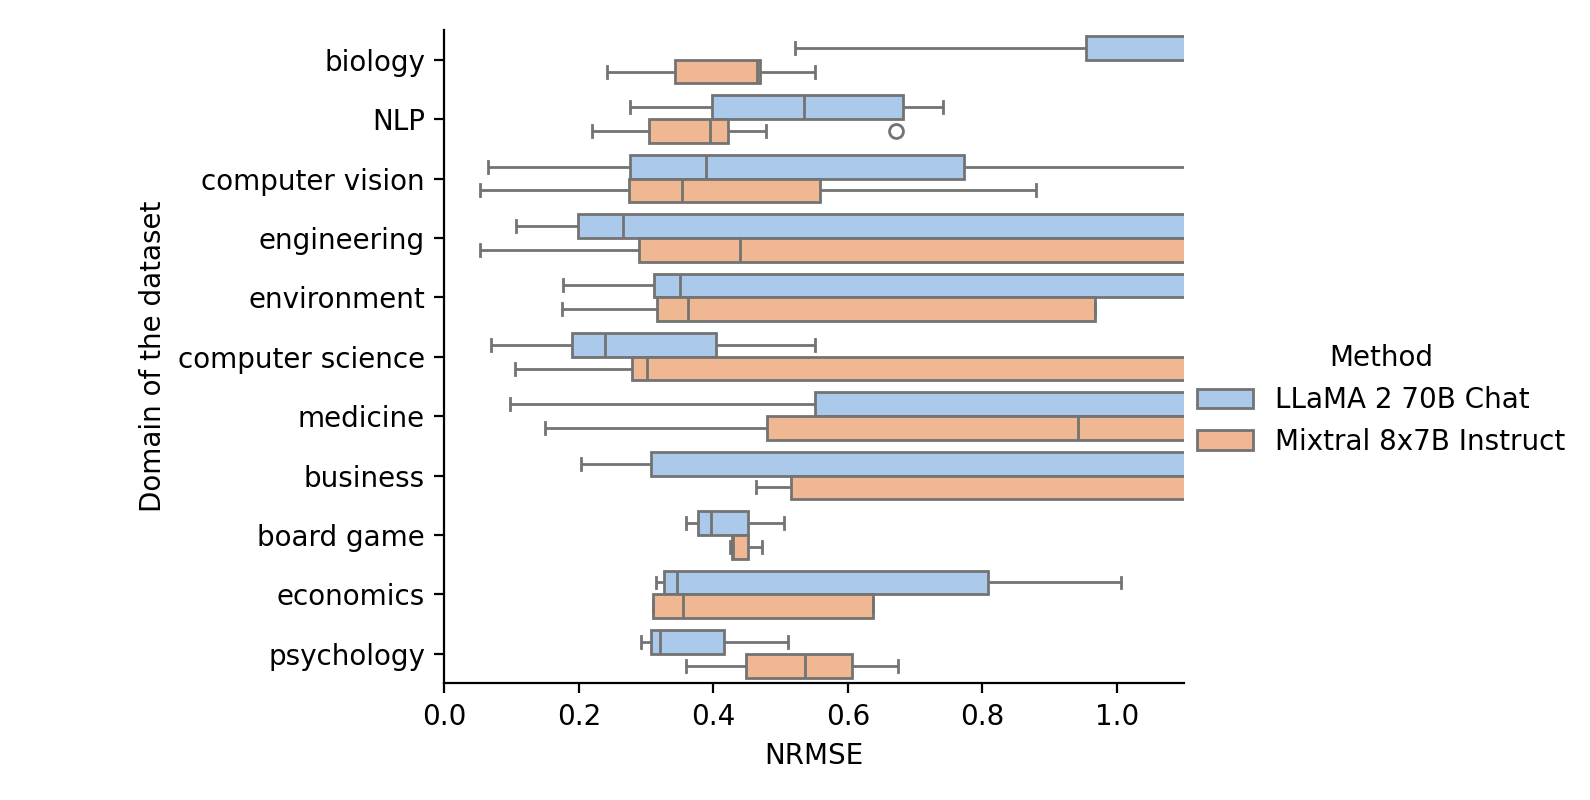

In [24]:
g = sns.catplot(
  data=llm_rmse_df, x="rmse", y="category", hue="method", palette='pastel',
  kind="box", height=4, aspect=1.5,
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/nrmse-domain-llm.pdf', bbox_inches='tight')

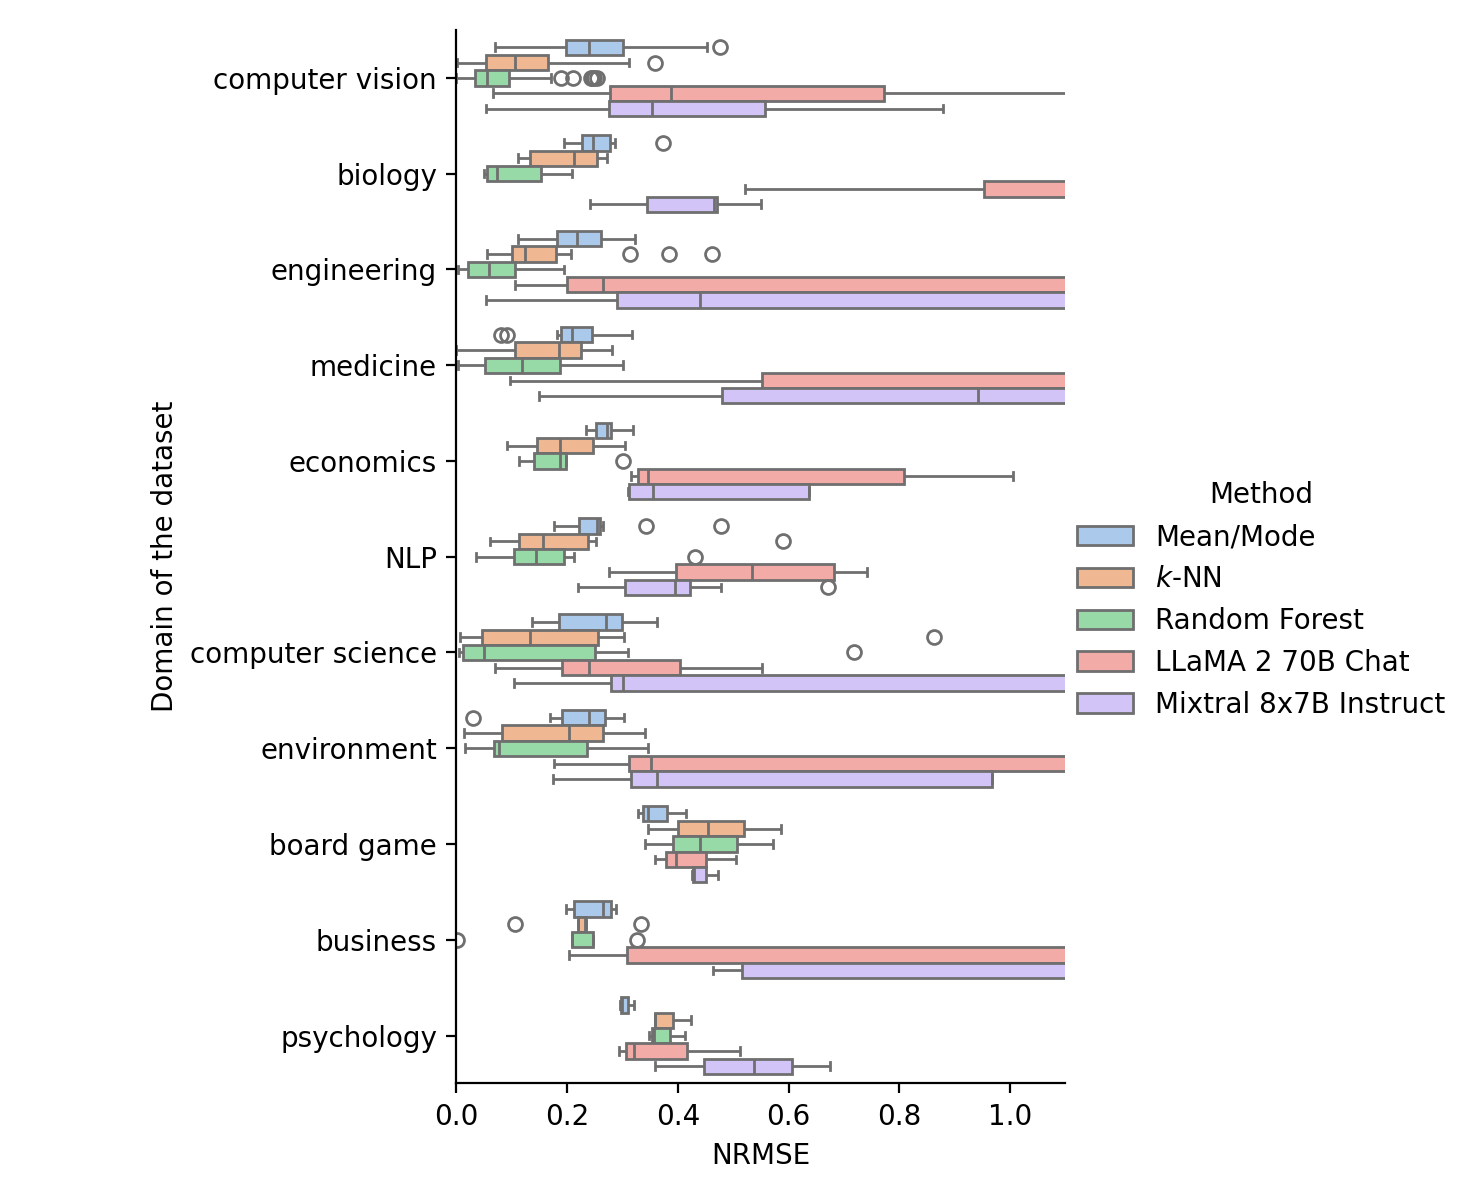

In [25]:
g = sns.catplot(
  data=rmse_df, x="rmse", y="category", hue="method", palette='pastel',
  kind="box", height=6, aspect=0.9
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/nrmse-domain-all.pdf', bbox_inches='tight')

## $F_1$ score

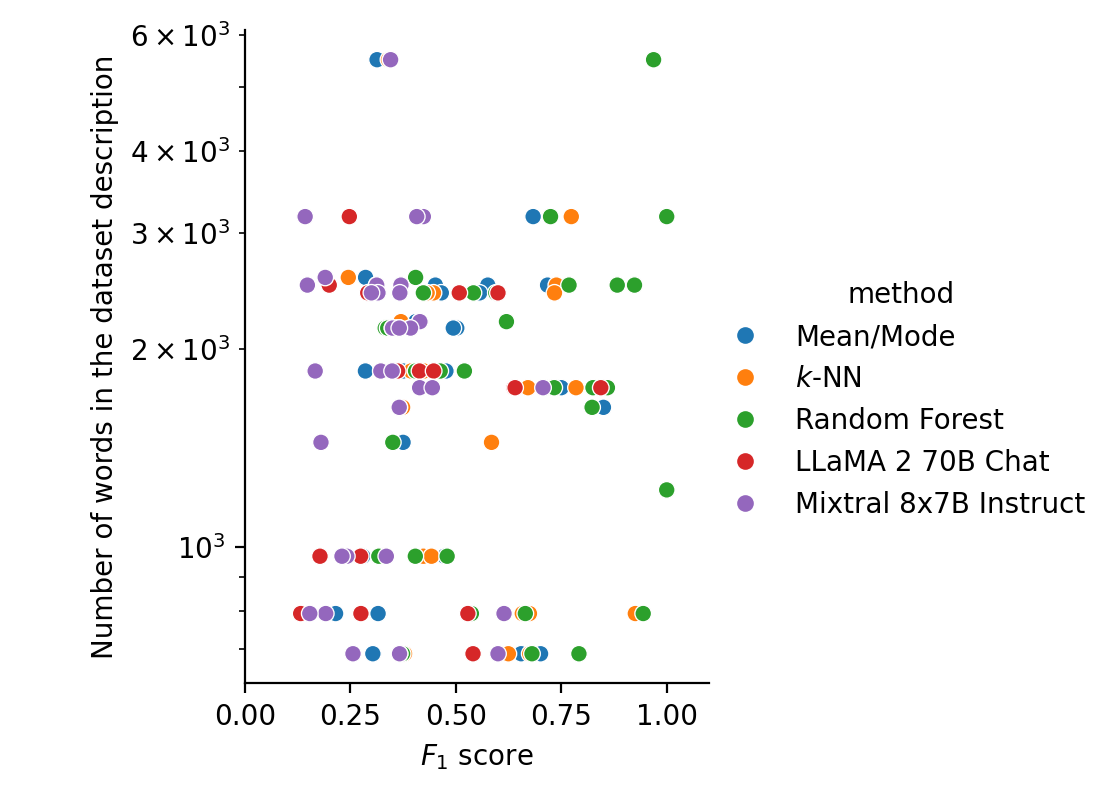

In [26]:
g = sns.relplot(
    data=macro_f1_df, x='macro_f1', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Number of words in the dataset description')
g.ax.set_yscale('log')
g.ax.set_xlim(0, 1.1)
g.fig.savefig(output_dirpath / 'fig/f1-desclength-all.pdf', bbox_inches='tight')

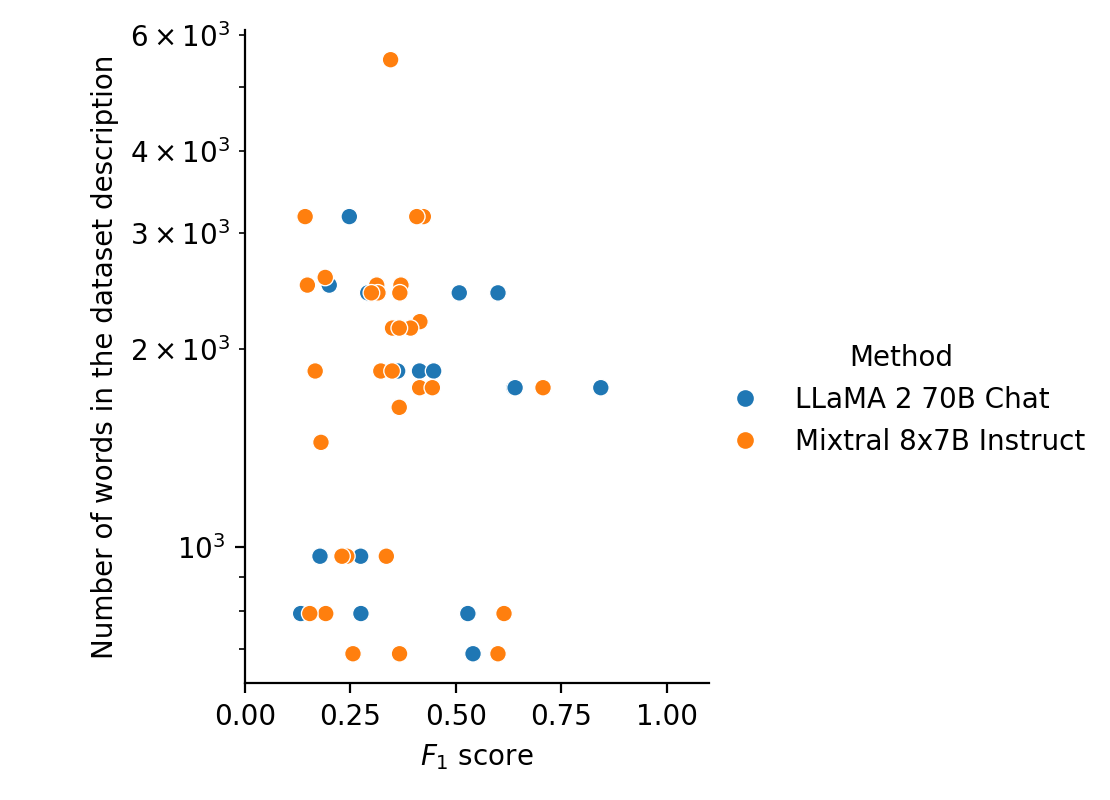

In [27]:
g = sns.relplot(
    data=llm_macro_f1_df, x='macro_f1', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Number of words in the dataset description')
g.legend.set_title('Method')
g.ax.set_yscale('log')
g.ax.set_xlim(0, 1.1)
g.fig.savefig(output_dirpath / 'fig/f1-desclength-llm.pdf', bbox_inches='tight')

(0.0, 1.1)

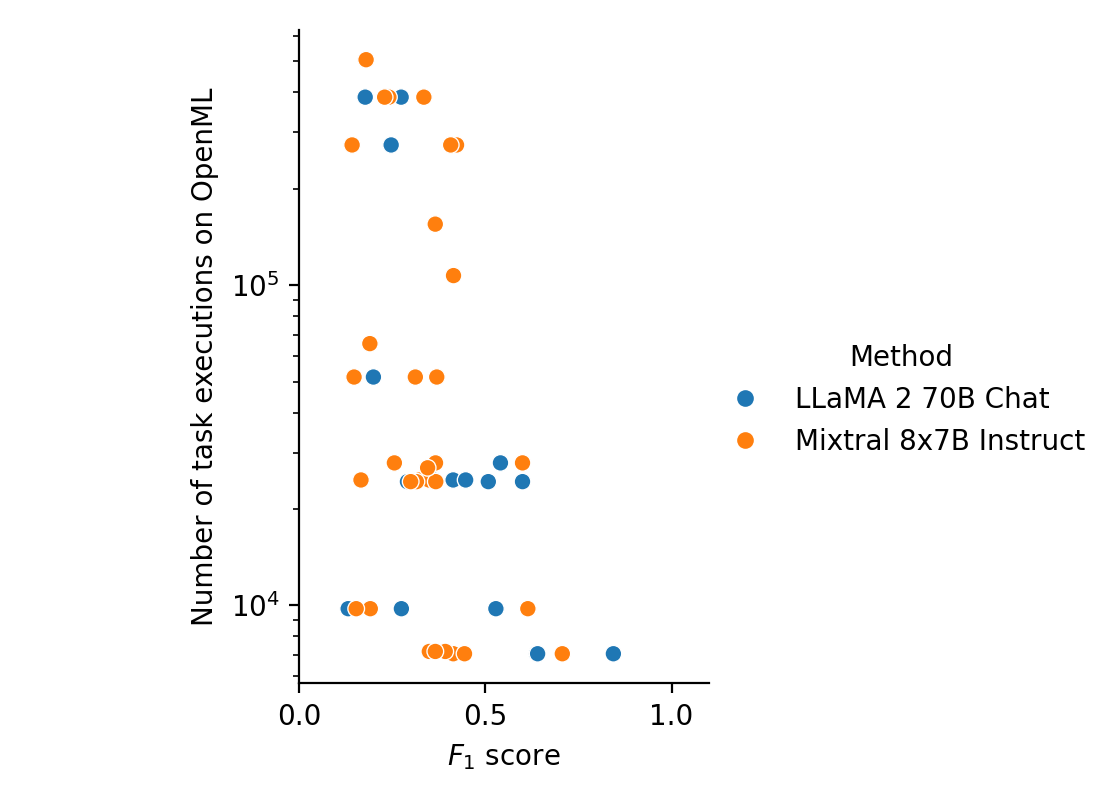

In [28]:
g = sns.relplot(
    data=llm_macro_f1_df, x='macro_f1', y='tasks_runs', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Number of task executions on OpenML')
g.legend.set_title('Method')
g.ax.set_yscale('log')
g.ax.set_xlim(0, 1.1)
# g.fig.savefig(output_dirpath / 'fig/f1-desclength-llm.pdf', bbox_inches='tight')

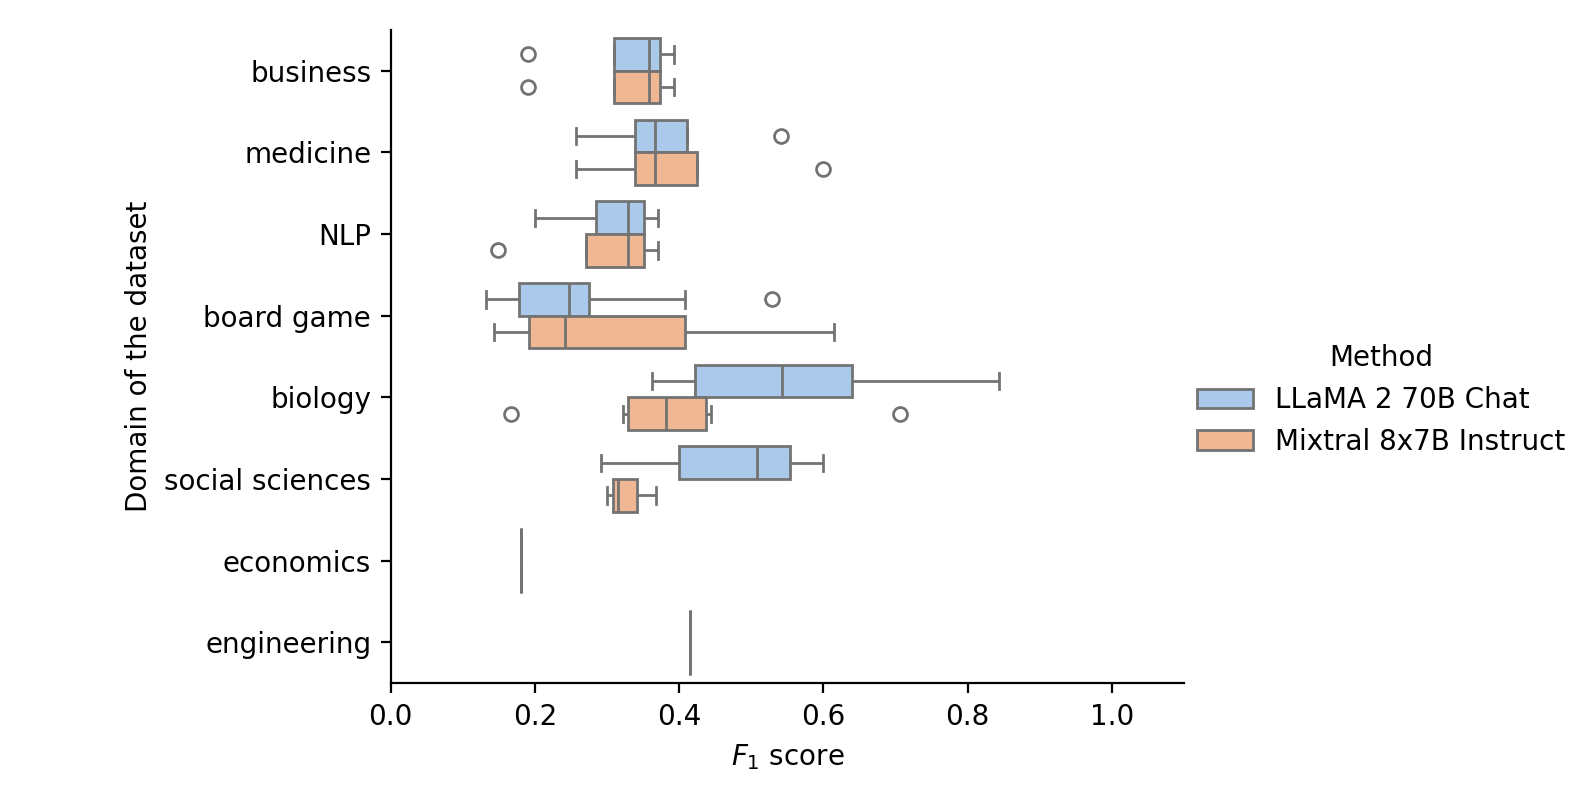

In [29]:
g = sns.catplot(
  data=llm_macro_f1_df, x="macro_f1", y="category", hue="method", palette='pastel',
  kind="box", height=4, aspect=1.5,
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/f1-domain-llm.pdf', bbox_inches='tight')

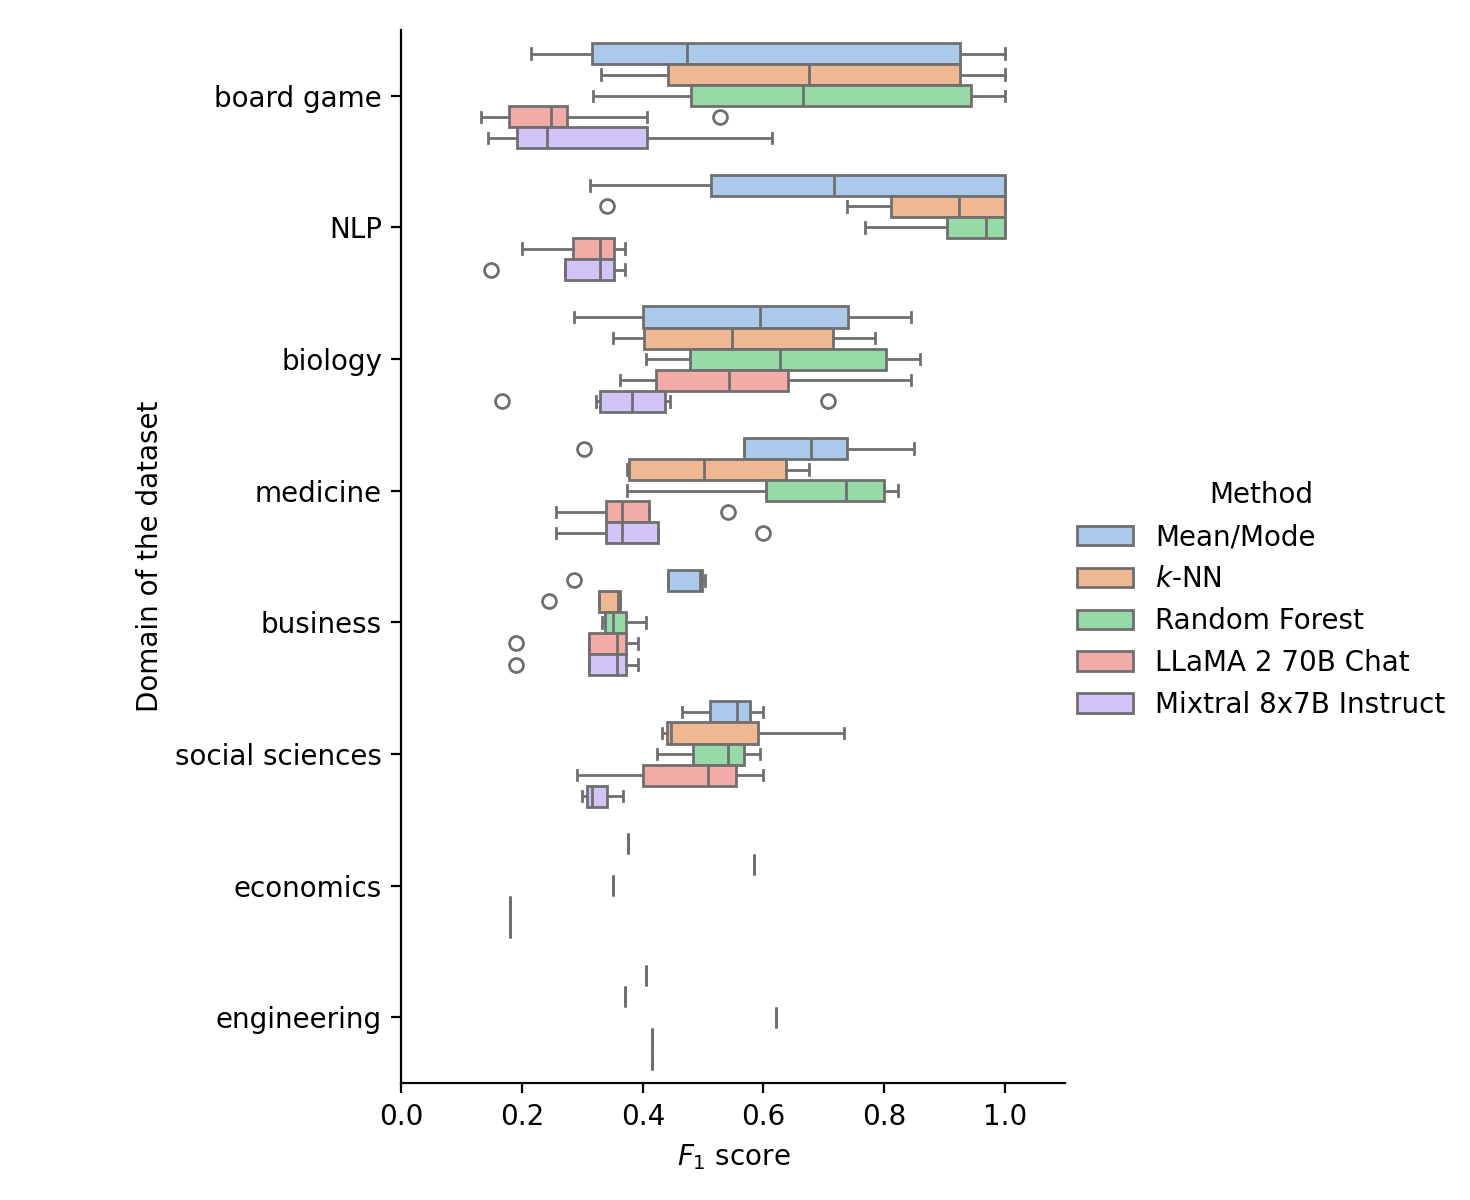

In [30]:
g = sns.catplot(
  data=macro_f1_df, x="macro_f1", y="category", hue="method", palette='pastel',
  kind="box", height=6, aspect=0.9
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/f1-domain-all.pdf', bbox_inches='tight')

## Summarized plots

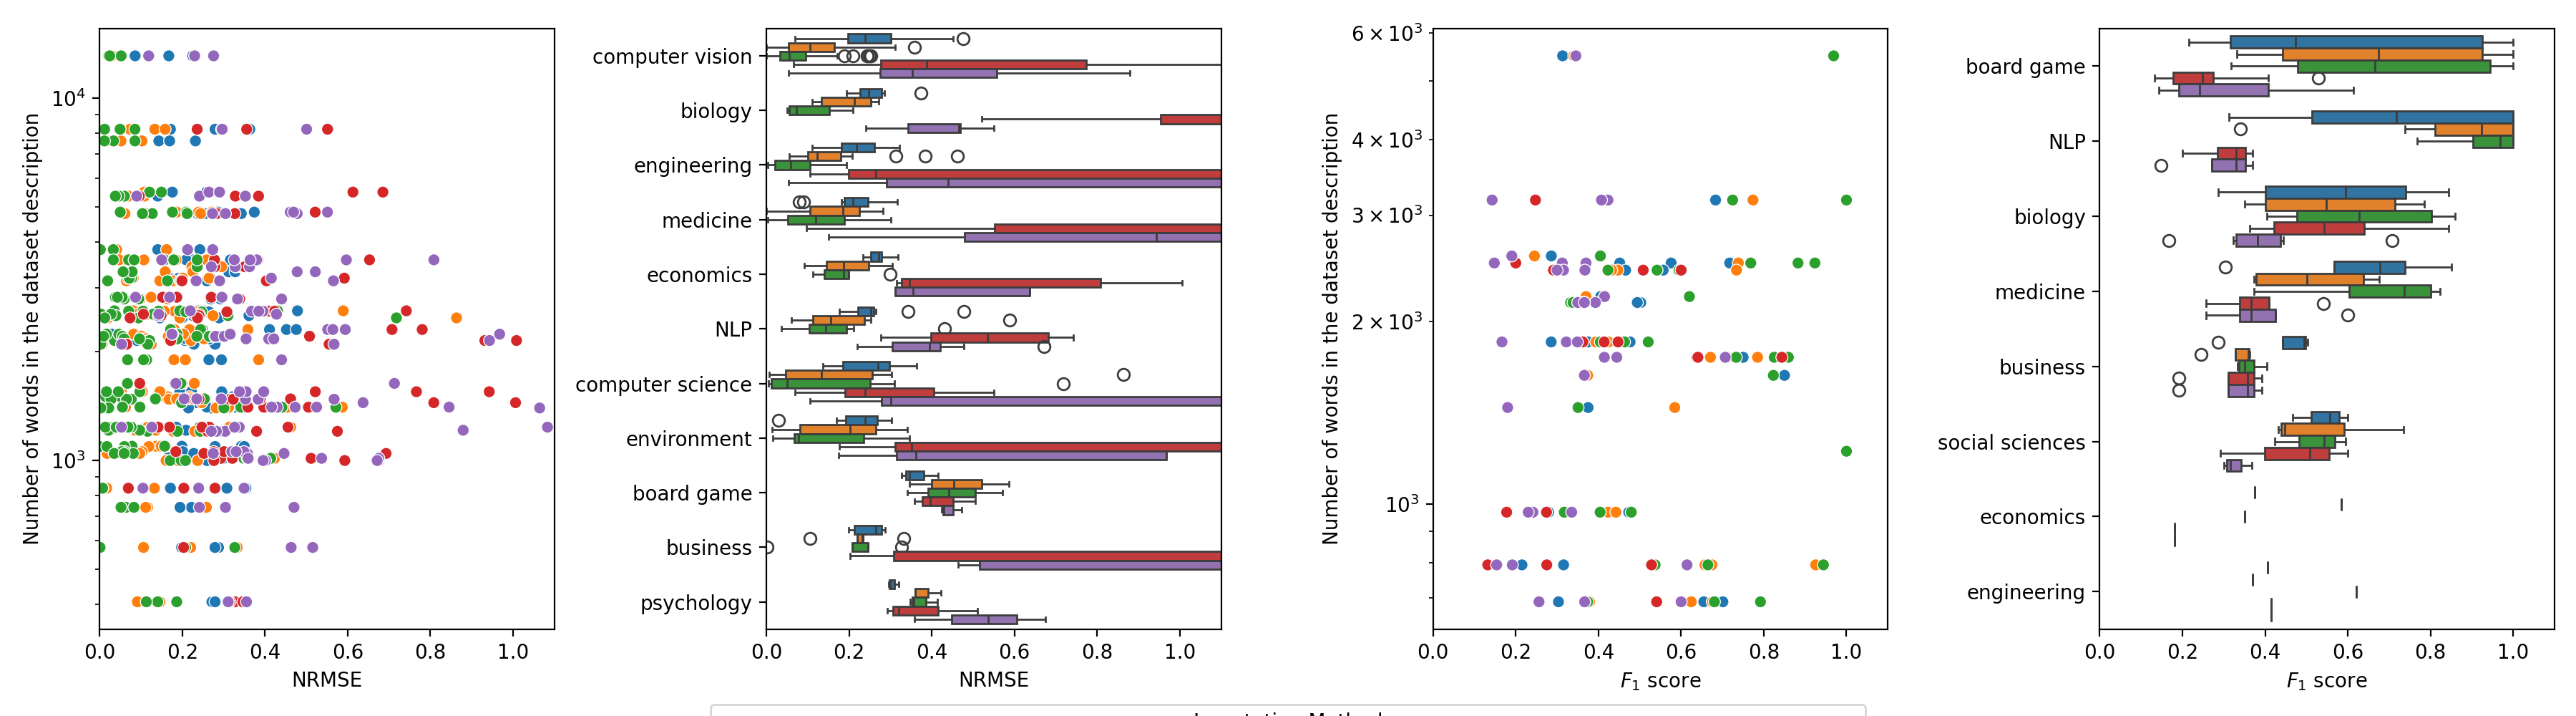

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(18, 5))  # サイズは必要に応じて調整

# NRMSE - Description Length
sns.scatterplot(
    data=rmse_df, x='rmse', y='openml_desc_len', hue='method', ax=axs[0]
)
axs[0].set_xlabel('NRMSE')
axs[0].set_ylabel('Number of words in the dataset description')
axs[0].set_yscale('log')
axs[0].set_xlim(0, 1.1)

# NRMSE - Domain
sns.boxplot(
    data=rmse_df, x="rmse", y="category", hue="method", ax=axs[1]
)
axs[1].set_xlim(0, 1.1)
axs[1].set_xlabel('NRMSE')
axs[1].set_ylabel('')

# F1 - Description Length
sns.scatterplot(
    data=macro_f1_df, x='macro_f1', y='openml_desc_len', hue='method', ax=axs[2]
)
axs[2].set_xlabel('$F_1$ score')
axs[2].set_ylabel('Number of words in the dataset description')
axs[2].set_yscale('log')
axs[2].set_xlim(0, 1.1)

# F1 - Domain
sns.boxplot(
    data=macro_f1_df, x="macro_f1", y="category", hue="method", ax=axs[3]
)
axs[3].set_xlim(0, 1.1)
axs[3].set_xlabel('$F_1$ score')
axs[3].set_ylabel('')

# Legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.09), ncol=7, title='Imputation Method')
for ax in axs.flat:
    ax.legend().set_visible(False)

# Output
plt.tight_layout()
plt.savefig(output_dirpath / 'fig/imputation-performance.pdf', bbox_inches='tight')
plt.show()

# Downstream performance

$$
\text{performance} = \frac{\text{accuracy}(\text{method}) - \text{accuracy}(\text{baseline})}{\text{accuracy}(\text{baseline})}
$$

In [32]:
# Calculate the mean of the downstream performance for each method and each description length

downstream_df_desclen_summary = downstream_df.drop(['openml_id', 'missingness', 'category'], axis=1)
downstream_df_desclen_summary = downstream_df_desclen_summary.groupby(['method', 'openml_desc_len']).mean().reset_index()
downstream_df_desclen_summary = downstream_df_desclen_summary.sort_values('method_id').reset_index(drop=True)
downstream_df_desclen_summary

,method,openml_desc_len,method_id,n_features,accuracy,macro_f1,tasks_runs,effect_accuracy,effect_macro_f1
0,Mean/Mode,2200,0.0,500.0,0.709615,0.709046,101204.0,1.095890,1.210396
1,Mean/Mode,1960,0.0,856.0,0.925926,0.920760,34579.0,0.000000,-0.101402
2,Mean/Mode,1895,0.0,27.0,0.771208,0.764473,9051.0,-0.662252,0.545108
3,Mean/Mode,1852,0.0,60.0,0.967085,0.963788,24646.0,0.652529,0.754800
4,Mean/Mode,1747,0.0,180.0,0.960815,0.957305,7063.0,0.000000,0.016809
...,...,...,...,...,...,...,...,...,...
295,Mixtral 8x7B Instruct,2820,6.0,36.0,0.923017,0.907625,30180.0,0.000000,-0.002494
296,Mixtral 8x7B Instruct,2789,6.0,64.0,0.980427,0.980017,36118.0,0.547445,0.563431
297,Mixtral 8x7B Instruct,2587,6.0,57.0,0.956569,0.955165,162017.0,0.456100,0.484282
298,Mixtral 8x7B Instruct,4799,6.0,5.0,0.908418,0.889427,218957.0,0.511771,0.547423


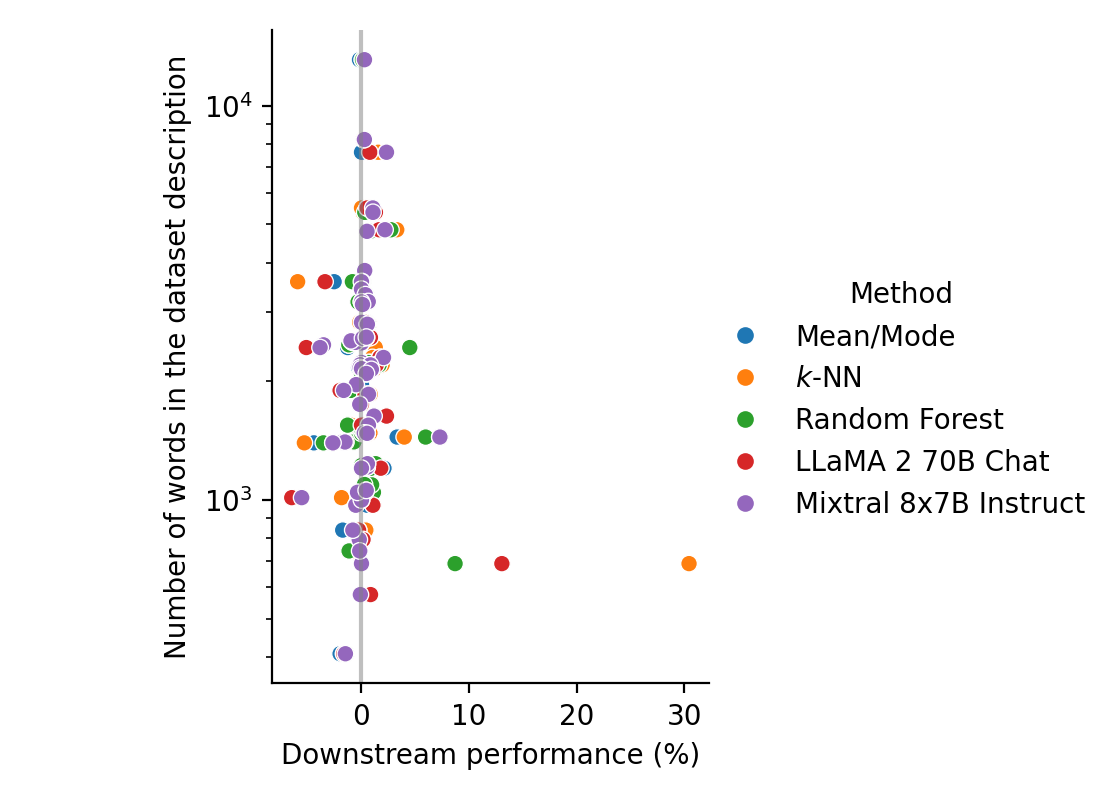

In [33]:
g = sns.relplot(
    data=downstream_df_desclen_summary, x='effect_accuracy', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('Downstream performance (%)')
g.ax.set_ylabel('Number of words in the dataset description')
g.legend.set_title('Method')
g.ax.set_yscale('log')
g.ax.axvline(x=0, color='gray', alpha=0.5)

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence inter

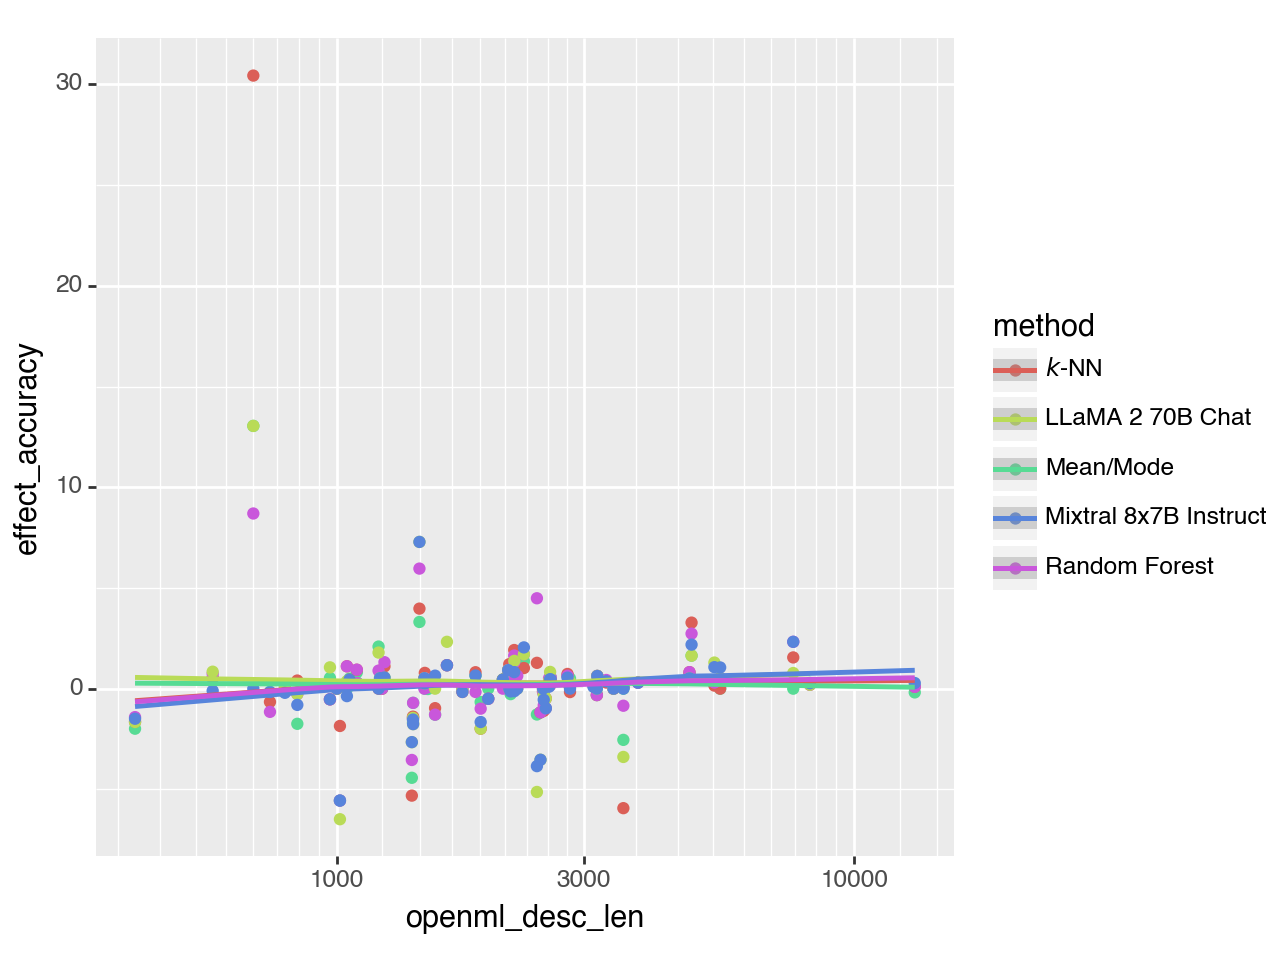

<Figure Size: (640 x 480)>

In [34]:
(
    p9.ggplot(
        data=downstream_df_desclen_summary, 
        mapping=aes(x='openml_desc_len', y='effect_accuracy', color='method')
    )
    + p9.geom_point()
    + p9.geom_smooth()
    + p9.scale_x_log10()
)

In [35]:
downstream_df_domain_summary = downstream_df.drop(['openml_id', 'openml_desc_len', 'missingness'], axis=1)
downstream_df_domain_summary = downstream_df_domain_summary.groupby(['method', 'category']).mean().reset_index()
downstream_df_domain_summary = downstream_df_domain_summary.sort_values('method_id').reset_index(drop=True)

In [36]:
downstream_df_domain_summary.drop(['n_features', 'accuracy', 'macro_f1', 'tasks_runs', 'effect_macro_f1'], axis=1).groupby(['category', 'method', 'method_id']).apply(lambda x: x.sort_values('effect_accuracy')).reset_index(drop=True)

/var/folders/mr/qc9n5qqn4jjgn6jh4mpcfsgm0000gn/T/ipykernel_77343/2665843772.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,method,category,method_id,effect_accuracy
0,$k$-NN,NLP,1.0,0.097652
1,LLaMA 2 70B Chat,NLP,4.0,0.349695
2,Mean/Mode,NLP,0.0,0.176341
3,Mixtral 8x7B Instruct,NLP,6.0,0.231593
4,Random Forest,NLP,2.0,0.151467
5,$k$-NN,biology,1.0,0.818331
6,LLaMA 2 70B Chat,biology,4.0,0.655203
7,Mean/Mode,biology,0.0,0.531850
8,Mixtral 8x7B Instruct,biology,6.0,0.627679
9,Random Forest,biology,2.0,0.354448


Text(94.42649652777779, 0.5, 'Domain of the dataset')

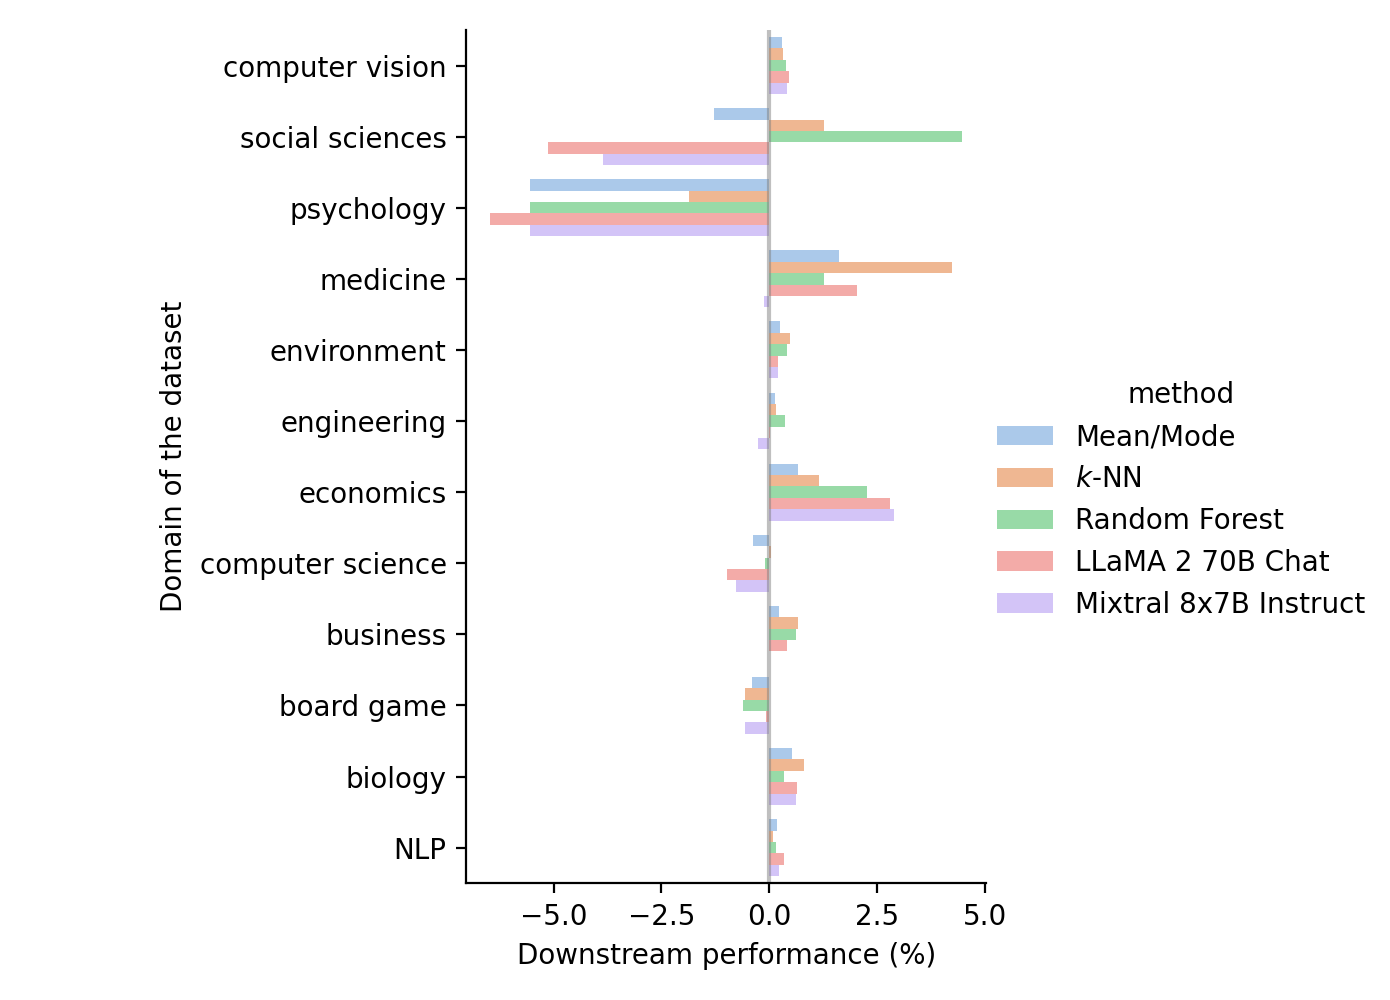

In [37]:
g = sns.catplot(
    data=downstream_df_domain_summary, x="effect_accuracy", y="category", hue="method", palette='pastel',
    kind="bar"
)
g.ax.axvline(x=0, color='gray', alpha=0.5)
g.ax.set_xlabel('Downstream performance (%)')
g.ax.set_ylabel('Domain of the dataset')

## Summarized plots

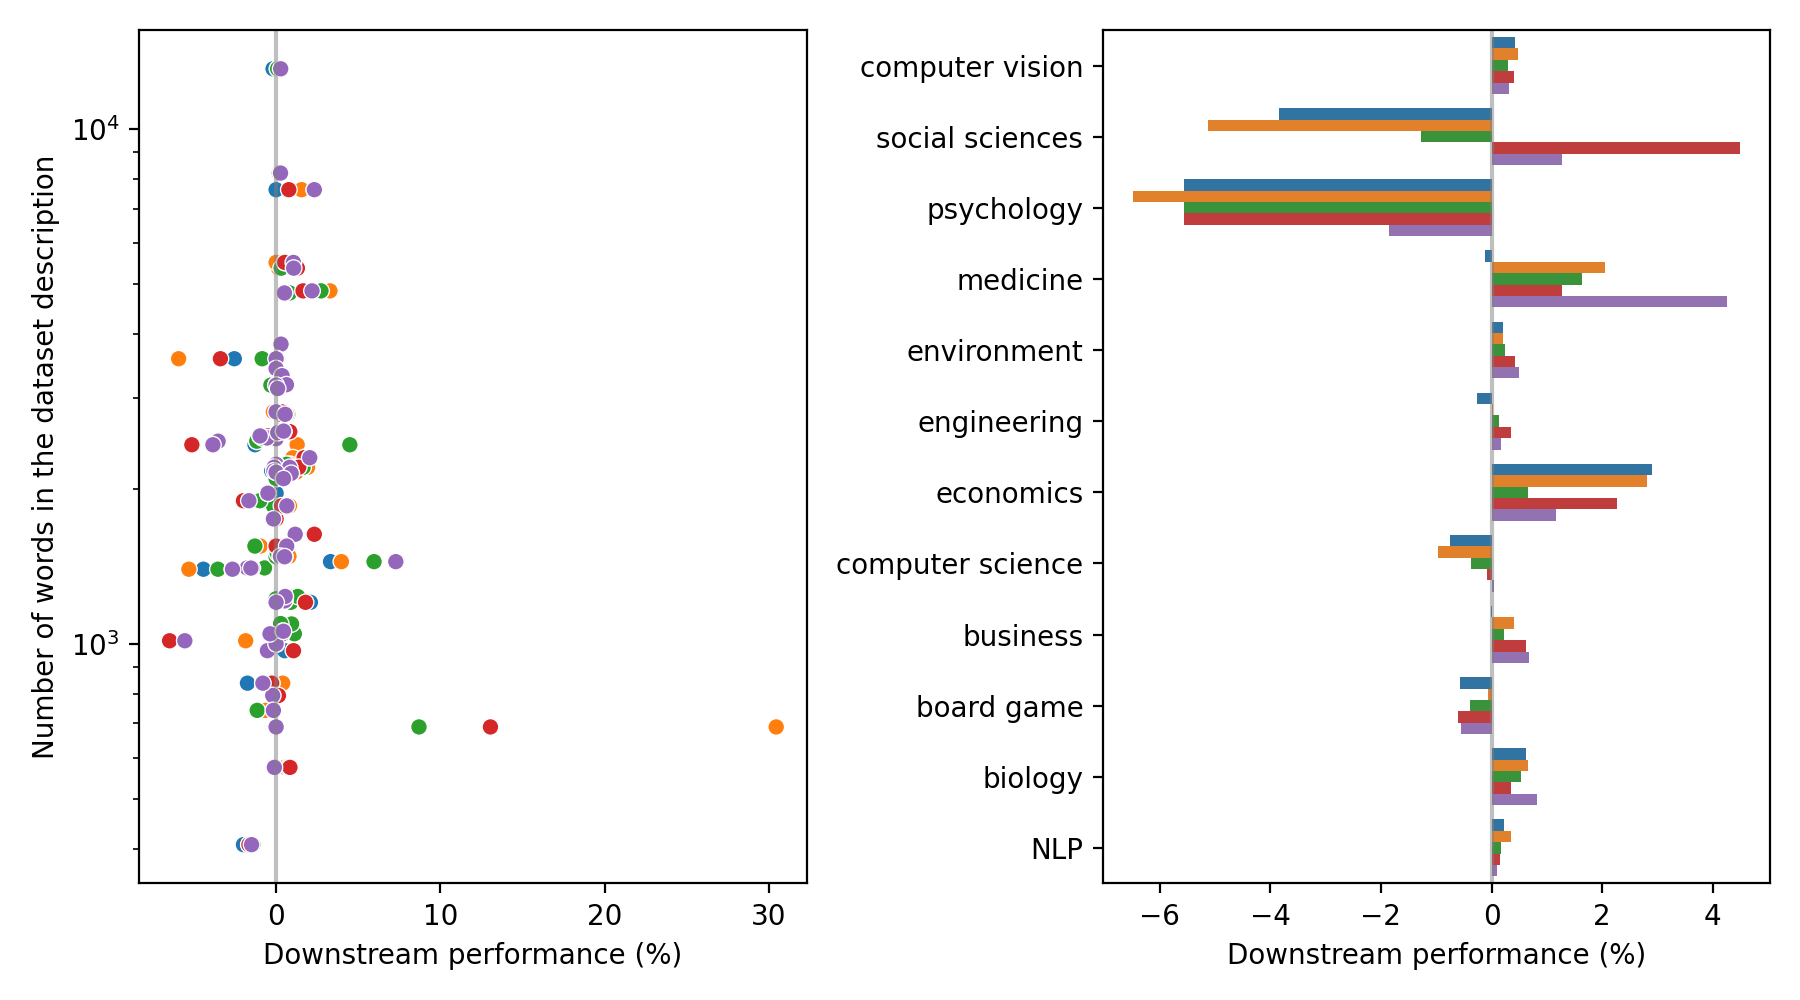

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))  # サイズは必要に応じて調整

# Downstream performance - Description Length
sns.scatterplot(
    data=downstream_df_desclen_summary, x='effect_accuracy', y='openml_desc_len', hue='method', ax=axs[0]
)
axs[0].set_xlabel('Downstream performance (%)')
axs[0].set_ylabel('Number of words in the dataset description')
axs[0].set_yscale('log')
axs[0].axvline(x=0, color='gray', alpha=0.5)

# Downstream performance - Domain
sns.barplot(
    data=downstream_df_domain_summary, x="effect_accuracy", y="category", hue="method", ax=axs[1], 
    hue_order=downstream_df_domain_summary.drop(['category'], axis=1).groupby('method').mean().sort_values('effect_accuracy').index,
)
axs[1].set_xlabel('Downstream performance (%)')
axs[1].set_ylabel('')
axs[1].axvline(x=0, color='gray', alpha=0.5)

# Legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4, title='Imputation Method')
for ax in axs.flat:
    ax.legend().set_visible(False)

# Output
plt.tight_layout()
plt.savefig(output_dirpath / 'fig/downstream.pdf', bbox_inches='tight')
plt.show()

## Summary in table

In [39]:
downstream_df_summarized = downstream_df.drop(['openml_id', 'openml_desc_len', 'missingness', 'category'], axis=1)
downstream_df_summarized = downstream_df_summarized.groupby(['method']).mean().reset_index()
downstream_df_summarized = downstream_df_summarized.sort_values('method_id').reset_index(drop=True)

In [40]:
downstream_df_summarized

,method,method_id,n_features,accuracy,macro_f1,tasks_runs,effect_accuracy,effect_macro_f1
0,Mean/Mode,0.0,216.53125,0.863099,0.806426,83532.765625,0.177527,0.901315
1,$k$-NN,1.0,216.53125,0.864354,0.808092,83532.765625,0.567853,1.352539
2,Random Forest,2.0,216.53125,0.864720,0.809029,83532.765625,0.367544,1.265953
3,LLaMA 2 70B Chat,4.0,43.132075,0.863203,0.795878,95290.150943,0.250699,1.204003
4,Mixtral 8x7B Instruct,6.0,123.666667,0.867053,0.806779,89066.783333,0.014484,0.726892
